# Importing Libraries

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import string
import nltk
from nltk.corpus import stopwords
from itertools import combinations
from sklearn.manifold import MDS
from collections import Counter
from tqdm import tqdm



from selenium import webdriver
from selenium.webdriver.common.by import By
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Scraping User Comments

**Order of comments: Latest First**

User

In [258]:
user = comments[-1].find_element(By.CLASS_NAME, "Username.js-userCard.js-userCardInitialized").text
user

'carnaught'

Posts

In [210]:
posts = elements[0].find_element(By.CLASS_NAME, 'MItem.PostCount').text.split()[-1].replace(',','')
posts

'235085'

Time

In [214]:
time = elements[0].find_element(By.TAG_NAME, 'time').get_attribute("datetime")
time

'2020-02-25T19:38:57+00:00'

Comment

In [260]:
backquote = comments[-1].find_element(By.CLASS_NAME, 'QuoteText.blockquote-content').text.replace('show previous quotes', '').split()

backquote = ' '.join(backquote)

In [261]:
backquote

'@explorerx4 : How do you like your Lincoln MKZ? As you may have seen, a friend of mine just got a 2018 MKZ and so far he loves it.'

In [272]:
comment_text = comments[-1].find_element(By.CLASS_NAME, 'Message.userContent').text.strip().split()

comment_text = ' '.join(comment_text)
comment_text

'benjaminh said: @explorerx4 : How do you like your Lincoln MKZ? As you may have seen, a friend of mine just got a 2018 MKZ and so far he loves it. It’s a nice car. They should have updated instead of eliminating it.'

In [266]:
comment_text = comment_text.replace(backquote, "").strip()

In [267]:
comment_text

'benjaminh said:  It’s a nice car. They should have updated instead of eliminating it.'

## Extracting 5000 most recent comments

In [275]:
wd = webdriver.Chrome(options=chrome_options)

In [1]:
n = 5000
data = {'comments':[]}
user_dict = {}
posts_dict = {}
time_dict = {}
i = 435

while len(data['comments'])<n:
    
    url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'+'/p'+str(i)
    wd.get(url)
    comments = wd.find_elements(By.CLASS_NAME, 'Comment')
    
    for comment in reversed(comments):
        user = comment.find_element(By.CLASS_NAME, "Username.js-userCard.js-userCardInitialized").text
        posts = comment.find_element(By.CLASS_NAME, 'MItem.PostCount').text.split()[-1].replace(',','')
        time = comment.find_element(By.TAG_NAME, 'time').get_attribute("datetime")

        try:
            backquote = comment.find_element(By.CLASS_NAME, 'QuoteText.blockquote-content')\
            .text.replace('show previous quotes', '').split()
            backquote = ' '.join(backquote)
        except:
            backquote = ''

        comment_text = comment.find_element(By.CLASS_NAME, 'Message.userContent').text.strip().split()
        comment_text = ' '.join(comment_text)

        if backquote!='':
            comment_text = comment_text.replace(backquote, "").strip()

        user_dict[comment_text] = user
        posts_dict[comment_text] = posts
        time_dict[comment_text] = time


        if comment_text not in data:
            data['comments'].append(comment_text)
    
    i = i - 1

In [327]:
comments_df = pd.DataFrame(data)
user_df = pd.DataFrame(list(user_dict.items()), columns=['comments', 'username'])
time_df = pd.DataFrame(list(time_dict.items()), columns=['comments', 'time'])
posts_df = pd.DataFrame(list(posts_dict.items()), columns=['comments', 'posts_count'])

# Merge DataFrames
merged_df = comments_df.merge(user_df, on='comments').merge(time_df, on='comments').merge(posts_df, on='comments')

In [338]:
a = merged_df

In [340]:
a.drop_duplicates(inplace=True)

In [344]:
# a.iloc[:5000,:].to_csv('5000.csv', index=False)

# Replace Car Models with Brands

In [193]:
df = pd.read_csv('5000.csv') #comments dataframe

## Importing Brand-Model data

In [194]:
brands_df = pd.read_csv('car_models_and_brands.csv') #brands and models database

Let's check for anomalies in this dataset...

In [195]:
brands_df[brands_df['Brand'] == 'car']

,Brand,Model
52,car,cars


dropping the brand 'car', 'seat', 'sedan', and 'problem'

In [198]:
brands_df.drop(brands_df[brands_df['Brand'].isin(['car', 'sedan', 'seat', 'problem'])].index, inplace=True)

dataset mentions two similar models...

In [199]:
brands_df[brands_df['Model'].map(lambda x: '/' in x)]

,Brand,Model
410,toyota,corolla/sprinter


In [200]:
def generate_corpus(column):
    corpus = " "
    for text in column:
        text = str(text)
        for i in list(string.punctuation.replace('+','')):
            text = text.replace(i, ' ')
        text = text.lower()

        corpus += text
    return corpus

In [201]:
corpus_words = generate_corpus(df['comments'])

In [202]:
corpus_words.count('sprinter')

0

In [203]:
brands_df.loc[brands_df['Model'].map(lambda x: '/' in x)] = 'corolla'

Let's check if there are spaces or punctuations in between the model names...

In [204]:
[x for x in brands_df['Model'] if any(char in string.whitespace for char in x)][:3]

['park avenue', 'la crosse', 'grand blazer']

In [205]:
[x for x in brands_df['Model'] if any(char in string.punctuation for char in x)]

['3-series',
 '5-series',
 '6-series',
 '4-series',
 's-10',
 'f-150',
 'c-max',
 's-max',
 'n-box',
 'n-one',
 'n-wgn',
 'cr-v',
 'ex-l',
 'cr-z',
 'excel,',
 'excel.',
 'az-offroad',
 'az-wagon',
 'rx-8',
 'cx-7',
 'bt-50',
 'rx-8',
 'mx-5',
 'cx-5',
 'cx-9',
 'mercedes-benz',
 'cl-class',
 'c-class',
 'e-class',
 's-class',
 'quest.',
 'quest,',
 'x-90']

Dictionary with Model: Brand mapping
> The dictionary will map the brands with their corresponding model names

In [206]:
brand_model = {}
for brand, model in zip(brands_df['Brand'], brands_df['Model']):
    if brand not in brand_model.keys():
        brand_model[brand] = []
    brand_model[brand].append(model)
    for j in list(string.punctuation + string.whitespace):
            if j in model: 
                model1 = model.replace(j,'')
                brand_model[brand].append(model1)
            else: continue

Replacing models with Brands

In [207]:
#function to clean the list of scraped comments
def clean(column):
    data = list(column)
    for i in range(len(data)):
        text = str(data[i])
        for punct in list(string.punctuation):
             text = text.replace(punct, ' ')
        text = text.lower()
        data[i] = text
    return data

In [208]:
comments_list = clean(df['comments']) #list of clean comments 

In [209]:
def replace_brands(wordlist, dic):
    count=0
    for brand, models in dic.items():
        for i in range(len(wordlist)):
            for model in models:
                if model in wordlist[i]:
                    wordlist[i] = wordlist[i].replace(model, ' '+ brand + ' ')
                    count+=1
    return wordlist, count

In [210]:
clean_comments, replaced = replace_brands(comments_list, brand_model)

In [211]:
replaced

8212

# Top 10 brands

As per brand mentions in user conversations

In [212]:
brand_count = {}
for brand in brand_model.keys():
    brand_count[brand] = 0

for i in range(len(clean_comments)):
    text = clean_comments[i].split()
    for brand in list(brand_count.keys()):
        if brand in text:
            brand_count[brand] += 1

In [213]:
brand_freq = []
for brand, count in brand_count.items():
    brand_freq.append([brand, count])

brand_freq = pd.DataFrame(brand_freq, columns=['Brand', 'Count'])
brand_freq = brand_freq.sort_values('Count', ascending=False).reset_index(drop=True)
brand_freq[:10]

,Brand,Count
0,toyota,2500
1,bmw,1075
2,audi,953
3,honda,631
4,acura,552
5,chrysler,425
6,volkswagen,274
7,dodge,229
8,cadillac,222
9,mercedes-benz,212


In [214]:
top_10_brands = list(brand_freq['Brand'][:10])

# LIFT Ratios for Association

In [215]:
top_10_brands

['toyota',
 'bmw',
 'audi',
 'honda',
 'acura',
 'chrysler',
 'volkswagen',
 'dodge',
 'cadillac',
 'mercedes-benz']

In [216]:
def calculate_lift(comment, brand1, brand2, word_distance_threshold=6):
    tokens = comment.split()

    # generate all combinations of indices/words without repetition
    for i, j in combinations(brand1_indices + brand2_indices, 2):
        # Check if the word distance is within the threshold i.e. 6
        if abs(i - j) <= word_distance_threshold:
            lift_count += 1

    lift_ratio = (lift_count / total_count) / ((len(brand1_indices) / total_count) * (len(brand2_indices) / total_count))

    return lift_ratio

In [217]:
def lift(comments, brand1, brand2, words=float('inf')):
    n = len(comments)
    count_brand1 = 0
    count_brand2 = 0
    count_brand1_brand2 = 0

    for i in range(n):

        comment = comments[i].split()

        # storing indices of brands found in the comment
        brand1_indices = [i for i, word in enumerate(comment) if word == brand1]
        brand2_indices = [i for i, word in enumerate(comment) if word == brand2]

        both_brands = []    
        for brand1_index in brand1_indices:
            for brand2_index in brand2_indices:
                both_brands.append(abs(brand1_index - brand2_index)-1) # adding no of words in between brands
                                                                       # thus reducing by 1 as index starts at 0

        if len(both_brands) > 0:
            if float(min(both_brands)) <= float(words):
                count_brand1_brand2 += 1
        if len(brand1_indices) > 0:
            count_brand1 += 1
        if len(brand2_indices) > 0:
            count_brand2 += 1
    
    lift = (n * count_brand1_brand2) / (count_brand1 * count_brand2)
    return lift

In [218]:
example = ['toyota is way better than acura in my opinion',
 'acura and lexus are still way ahead than toyota', 'toyota is the most safe brand to buy at this point of time', 'i would advice to buy acura than toyota']

In [219]:
lift(example, 'toyota', 'acura', 6)

0.6666666666666666

In [220]:
lift_scores = []

for i in range(len(top_10_brands)):
    row = []

    for j in range(len(top_10_brands)):
        if j!=i:
            lift_score = lift(clean_comments, top_10_brands[i], top_10_brands[j])
            row.append(lift_score)
        elif i==j:
            row.append(1)
    
    row.append(top_10_brands[i])
    lift_scores.append(row)

In [221]:
c = top_10_brands
c.append('Brand')
    
lift_scores = pd.DataFrame(lift_scores, columns=c).set_index('Brand')
display(lift_scores)

,toyota,bmw,audi,honda,acura,chrysler,volkswagen,dodge,cadillac,mercedes-benz
Brand,,,,,,,,,,
toyota,1.000000,1.138605,1.177335,1.223455,1.065217,1.011765,1.233577,1.283843,1.288288,1.254717
bmw,1.138605,1.000000,1.854608,1.385766,1.449275,1.225718,1.307079,1.279578,1.990362,3.400614
audi,1.177335,1.854608,1.000000,1.845868,2.081527,1.752978,2.374369,1.970335,2.741461,3.291493
honda,1.223455,1.385766,1.845868,1.000000,2.899699,2.703459,1.821926,1.695513,1.748976,2.317376
acura,1.065217,1.449275,2.081527,2.899699,1.000000,4.923274,1.289273,1.661287,2.570505,3.161745
chrysler,1.011765,1.225718,1.752978,2.703459,4.923274,1.000000,0.944611,1.952222,2.225755,2.275250
volkswagen,1.233577,1.307079,2.374369,1.821926,1.289273,0.944611,1.000000,1.115609,1.479582,1.979755
dodge,1.283843,1.279578,1.970335,1.695513,1.661287,1.952222,1.115609,1.000000,1.671978,1.956826
cadillac,1.288288,1.990362,2.741461,1.748976,2.570505,2.225755,1.479582,1.671978,1.000000,5.736869


# Multi-dimensional Scaling Plot

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


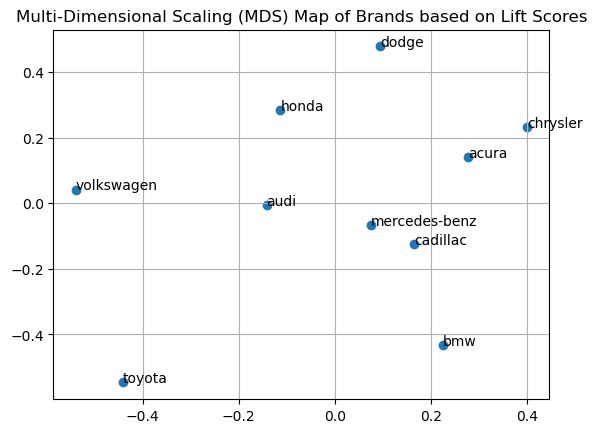

In [229]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result  = mds.fit_transform(1/lift_scores) # inputting dissimilarity as we have calculated similarity

# Plot the MDS map
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate points with brand names
for i, brand in enumerate(lift_scores.index):
    plt.annotate(brand, (mds_result[i, 0], mds_result[i, 1]))

plt.title("Multi-Dimensional Scaling (MDS) Map of Brands based on Lift Scores")
plt.grid(True)
plt.show()

# Top car attributes discussed

In [232]:
# let's remove stop words from the corpus of words

nltk.download('stopwords')

corpus_words_list = corpus_words.split()

stop_words = set(stopwords.words('english'))

filtered_corpus = [word for word in corpus_words_list if word.lower() not in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [239]:
word_counter = Counter(filtered_corpus)
top_n = 100  # Change this value to the desired number of top words
top_words = word_counter.most_common(top_n)

for word, count in top_words:
    print(f'{word}: {count}')

With the above we could identify following attributes that were discussed the most by users...

price: 601, performance: 448, engine: 434, luxury: 428, tires: 383, look: 355, speed: 337, seats: 334

In [254]:
brand_feature = list(brand_freq['Brand'][:10])
features = ['price', 'performance', 'engine', 'luxury', 'tires', 'look', 'speed', 'seats']

for feature in features:
    brand_feature.append(feature)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


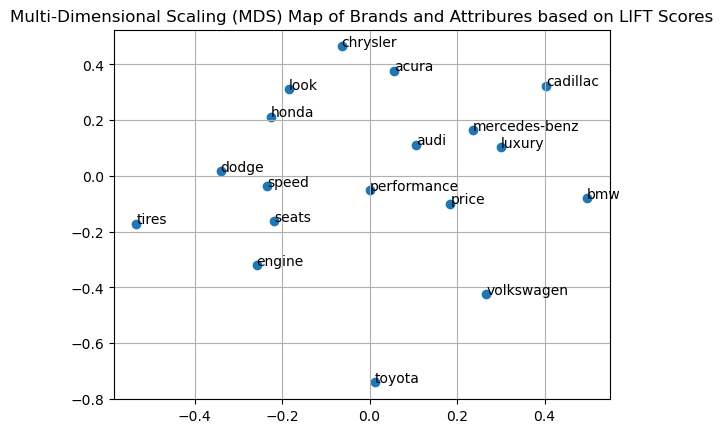

In [255]:
lift_scores = []

for i in range(len(brand_feature)):
    row = []

    for j in range(len(brand_feature)):
        if j!=i:
            lift_score = lift(clean_comments, brand_feature[i], brand_feature[j])
            row.append(lift_score)
        elif i==j:
            row.append(1)
    
    row.append(brand_feature[i])
    lift_scores.append(row)

c = brand_feature
c.append('Brand')
    
lift_scores = pd.DataFrame(lift_scores, columns=c).set_index('Brand')



mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result  = mds.fit_transform(1/lift_scores) # inputting dissimilarity as we have calculated similarity

# Plot the MDS map
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate points with brand names
for i, brand in enumerate(lift_scores.index):
    plt.annotate(brand, (mds_result[i, 0], mds_result[i, 1]))

plt.title("Multi-Dimensional Scaling (MDS) Map of Brands and Attribures based on LIFT Scores")
plt.grid(True)
plt.show()